In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_data(file_path):
    """
    Carga y prepara los datos con manejo adecuado de fechas
    """
    # Cargar el archivo con el formato de fecha correcto
    df = pd.read_csv(
        file_path, sep=';',             # Especificar el separador de columnas
        parse_dates=['Fecha'],          # Especificar la columna de fechas
        dayfirst=True                   # Indicar que el formato es DD-MM-YYYY
    )
    
    # Configurar la columna 'Fecha' como índice
    df.set_index('Fecha', inplace=True)
    df = df.asfreq('MS')
    
    # Para este análisis, nos enfocamos solo en SKU_25
    df_sku25 = df[['SKU_25']]
    
    return df

In [4]:
# Función para verificar estacionariedad y tipo de descomposición adecuada
def check_decomposition_type(df):
    # Analizar por ventanas temporales
    window_size = 12  # Para datos mensuales
    df_reset = df.reset_index()
    df_reset['window'] = df_reset.index // window_size
    window_stats = df_reset.groupby('window')['SKU_25'].agg(['mean', 'std'])
    
    # Calcular correlación entre media y desviación estándar
    correlation = np.corrcoef(window_stats['mean'], window_stats['std'])[0,1]
    
    # Determinar tipo de descomposición
    if correlation > 0.5:
        decomp_type = 'multiplicative'
        print(f"Correlación entre media y desv. estándar: {correlation:.4f}. Recomendación: modelo multiplicativo")
    else:
        decomp_type = 'additive'
        print(f"Correlación entre media y desv. estándar: {correlation:.4f}. Recomendación: modelo aditivo")
    
    return decomp_type

In [18]:
# Función para visualizar serie y componentes
def plot_series_components(df, decomp_type):
    # Realizar descomposición
    decomposition = seasonal_decompose(df['SKU_25'], model=decomp_type, period=12)
    
    # Visualizar componentes
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
    
    # Serie original
    ax1.plot(df.index, df['SKU_25'])
    ax1.set_title('Serie Original')
    ax1.set_xlabel('')
    
    # Tendencia
    ax2.plot(decomposition.trend)
    ax2.set_title('Tendencia')
    ax2.set_xlabel('')
    
    # Estacionalidad
    ax3.plot(decomposition.seasonal)
    ax3.set_title('Estacionalidad')
    ax3.set_xlabel('')
    
    # Residuos
    ax4.plot(decomposition.resid)
    ax4.set_title('Residuos')
    
    plt.tight_layout()
    return decomposition

In [16]:
# Función principal para análisis
def analyze_time_series(df):
    # Verificar tipo de descomposición apropiada
    decomp_type = check_decomposition_type(df)
    
    # Realizar descomposición y visualizar componentes
    decomposition = plot_series_components(df, decomp_type)
    
    # Verificar heteroscedasticidad
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.scatter(decomposition.trend.dropna(), abs(decomposition.resid.dropna()))
    ax.set_xlabel('Tendencia')
    ax.set_ylabel('Residuos Absolutos')
    ax.set_title('Diagnóstico de Heteroscedasticidad')
    plt.show()
    
    return df, decomposition

In [13]:
# Path del archivo CSV
file_path = "C:/Users/norma/OneDrive/Tecnoquimicas TQ/prueba_tq/data/data_productos.csv"
df = load_data(file_path)

Correlación entre media y desv. estándar: 0.1707. Recomendación: modelo aditivo


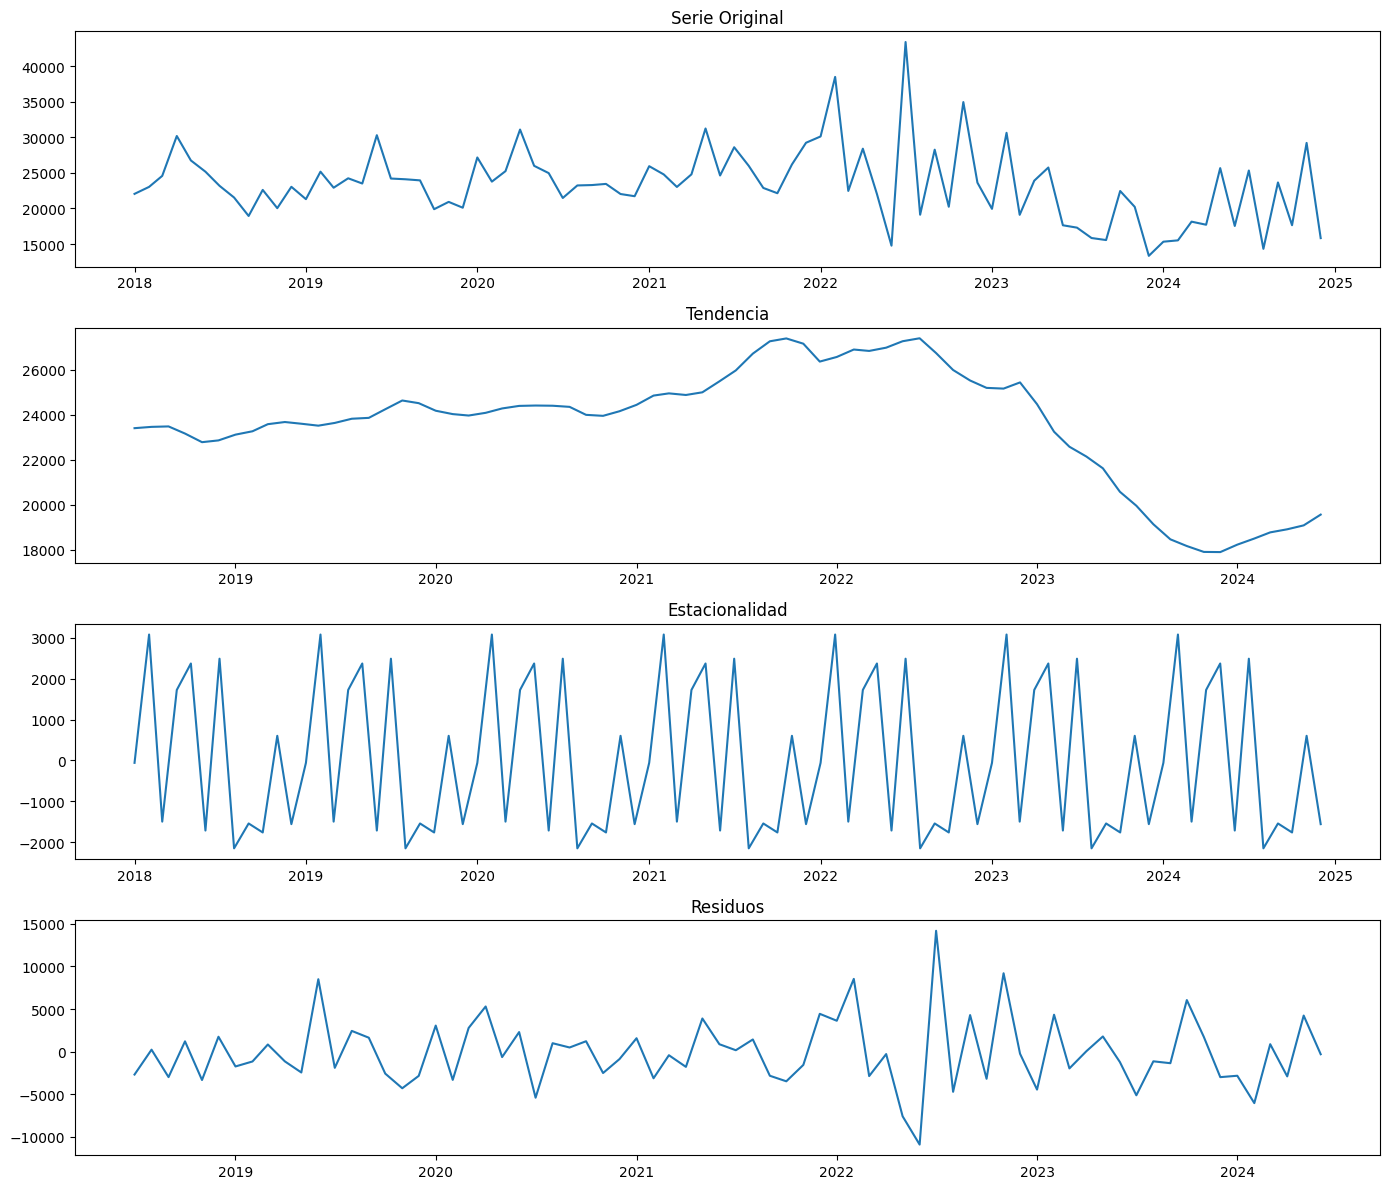

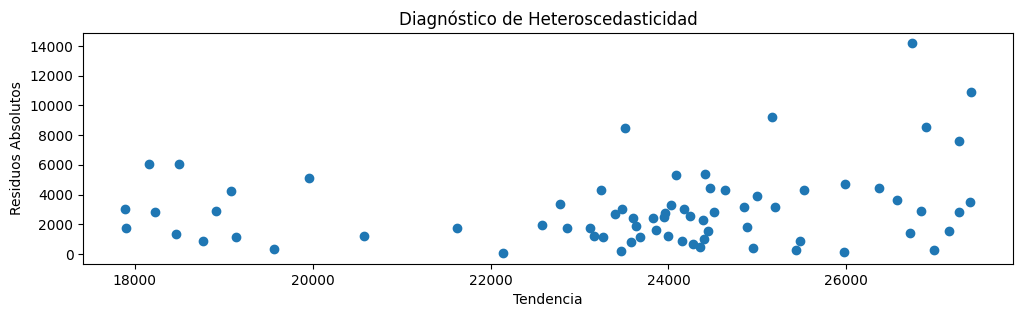

In [19]:
df, decomposition = analyze_time_series(df)

In [20]:
def ljung_box_test(df, lags=12, alpha=0.05):
    """
    Applies the Ljung-Box test for autocorrelation to a time series.

    Args:
        df (pd.Series or np.array): The time series data.
        lags (int or list, optional): The number of lags to test. Defaults to 12.
        alpha (float, optional): The significance level. Defaults to 0.05.

    Returns:
        pd.DataFrame: A DataFrame containing the Ljung-Box test results.
                      Includes the test statistic, p-value, and a boolean
                      indicating whether the null hypothesis (no autocorrelation)
                      is rejected.
        int: The count of lags where the null hypothesis is rejected.
    """
    # Ensure ts is a pandas Series to handle various input types
    if not isinstance(df, pd.Series):
        df = pd.Series(df)

    if isinstance(lags, int):
        lags = list(range(1, lags + 1))  # Create a list of lags from 1 to lags

    # Get results directly as DataFrame
    ljungbox_results = acorr_ljungbox(df, lags=lags, return_df=True)
    
    # Add column to indicate rejection of null hypothesis
    ljungbox_results['Reject H0'] = ljungbox_results['lb_pvalue'] < alpha
    
    # Count number of lags where null hypothesis is rejected
    rejected_count = ljungbox_results['Reject H0'].sum()

    return ljungbox_results, rejected_count

In [ ]:
# For testing with simulated data
np.random.seed(0)
simulated_ts = df

# Test the function with simulated data
ljungbox_df, rejected_count = ljung_box_test(simulated_ts, lags=12)

print(ljungbox_df)
print(f"Number of lags where the null hypothesis (no autocorrelation) is rejected: {rejected_count}")

# Example with a specific list of lags
lags_to_test = [1, 3, 5, 7, 9]
ljungbox_df_specific, rejected_count_specific = ljung_box_test(simulated_ts, lags=lags_to_test)
print("\nResults for specific lags:")
print(ljungbox_df_specific)
print(f"Number of lags where the null hypothesis (no autocorrelation) is rejected: {rejected_count_specific}")

# For real data from df
# ljungbox_df, rejected_count = ljung_box_test(df['Valor'], lags=12)